# Deviance information criterion (DIC)

https://www.rdocumentation.org/packages/SpatialExtremes/versions/2.0-7.2/topics/DIC

More information than you care to know here:  
https://pdfs.semanticscholar.org/cb82/02c3189cce0908a721e59f049438db8654c2.pdf

In [1]:
from jax import random
import jax.numpy as np
import numpy as onp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
numpyro.set_host_device_count(3)
numpyro.enable_validation()

## Define two models 

In [2]:
x = np.linspace(-1, 1)
t = 2.5 * x + onp.random.normal(loc=0, scale=.5, size=len(x))

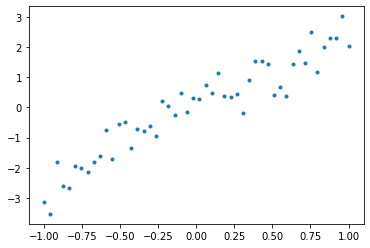

In [3]:
plt.plot(x, t, '.')

In [4]:
def model1_fn(x, t):
    m = numpyro.sample('m', dist.Normal(0, 1e6))
    # std = numpyro.sample('std', dist.InverseGamma(2.5, 2.5 * 10))
    std = numpyro.sample('std', dist.Exponential(1))

    y = m * x
    numpyro.sample('y', dist.Normal(y, std), obs=t)

kernel = NUTS(model1_fn)
model1 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model1.run(rng_key, collect_warmup=False, x=x, t=t)
samples1 = model1.get_samples()
model1.print_summary() 

/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/numpyro/infer/mcmc.py:630: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(3)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m      2.49      0.13      2.49      2.29      2.70  12478.56      1.00
       std      0.52      0.06      0.52      0.43      0.61  11553.16      1.00

Number of divergences: 0


In [5]:
def model2_fn(x, t):
    m1 = numpyro.sample('m1', dist.Normal(0, 1e6))
    m2 = numpyro.sample('m2', dist.Normal(0, 1e6))
    # std = numpyro.sample('std', dist.InverseGamma(2.5, 2.5 * 10))
    std = numpyro.sample('std', dist.Exponential(1))
    
    y = m1 * x + m2 * x**3
    numpyro.sample('y', dist.Normal(y, std), obs=t)

kernel = NUTS(model2_fn)
model2 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model2.run(rng_key, collect_warmup=False, x=x, t=t)
samples2 = model2.get_samples()
model2.print_summary() 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        m1      1.82      0.30      1.83      1.36      2.33   5798.47      1.00
        m2      1.06      0.44      1.06      0.36      1.80   5682.40      1.00
       std      0.50      0.05      0.49      0.42      0.58   6681.15      1.00

Number of divergences: 0


## DIC

The deviance is

$$
D(\theta) = -2 \log \pi(Y \mid \theta),
$$

where $y$ are the data, $\theta$ are the unknown parameters of the models and $\pi(Y|\theta)$ is the likelihood function. 

where 

$$
\pi(Y|\theta) = \prod_i^n \pi(y_i|\theta)
$$

and

$$
\log \pi(Y|\theta) = \sum_i^n \log \pi(y_i|\theta)
$$

for $n$ data points.

Thus the expected deviance, a measure of how well the model fits the data, is given by

$$
\overline{D} = {\rm E}_{\theta}[D(\theta)],
$$

while the effective number of parameters is

$$
p_D = \overline{D} - D(\theta^*),
$$

where $\theta^*$ is point estimate of the posterior distribution, e.g., the posterior mean. Finally the DIC is given by

$$
{\rm DIC} = p_D + \overline{D}.
$$


**Note**: This gets approximatly the correct answer, but isn't actually correct. Correct derivation is located below in the link

In [6]:
def dic(model_fn, samples, **kwargs):
    pi_theta = numpyro.infer.log_likelihood(model_fn, samples, **kwargs)['y'].sum(axis=1)
    # p = get_theta_prob(samples)
    D_bar = -2 * pi_theta.mean() # np.sum(pi_theta * p)
    theta_star = {k: v.mean(keepdims=True) for k, v in samples.items()}
    pi_theta_star = numpyro.infer.log_likelihood(model_fn, theta_star, **kwargs)['y'].sum()
    D_theta_star = -2 * pi_theta_star
    print('expected deviance:', D_bar)
    print('effective number of parameters:', D_bar - D_theta_star)
    print('DIC:', D_bar - D_theta_star + D_bar)

In [7]:
dic(model1_fn, samples1, x=x, t=t)

expected deviance: 76.3118
effective number of parameters: 1.9810944
DIC: 78.29289


In [8]:
dic(model2_fn, samples2, x=x, t=t)

expected deviance: 71.40388
effective number of parameters: 2.9178925
DIC: 74.32177


models with smaller DIC should be preferred to models with larger DIC. Roughly speaking, differences of more than 10 might rule out the model with the higher DIC, differences between 5 and 10 are substantial.

## Alternative calculation of DIC

I am not confident that $E_\theta[D(\theta)]$ works out to be the mean of $\log \pi(Y|\theta)$.

Strictly speaking _i think_ this should be:

$$
E_\theta[D(\theta)] = \int \log \pi(Y|\theta) P(\log \pi(Y|\theta)) d\theta
$$

I'm not really sure what, $P(\log \pi(Y|\theta))$, the probability of the log liklihood, would work out to be.

$$
E_\theta[D(\theta)] = \int \log \pi(Y|\theta) P(\theta) d\theta
$$

Makes a little more intuitive sense to me. i.e. What is the log liklihood weighted by the probability of the selected parameter.

However, I believe this would evaluate to 

$$
E_\theta[D(\theta)] = \int \log \pi(Y|\theta) \prod_i P(\theta_i) d\theta_i
$$

If we calculate this, $\prod_i P(\theta_i)$ ends up being an exceptionally small number for any of the $\theta$ combinations we pull


**Update**: Correct derivation is here

[J. R. Statist. Soc.B (2002)64, Part4, pp.583–639](https://rss.onlinelibrary.wiley.com/doi/epdf/10.1111/1467-9868.00353)

In [9]:
def get_theta_prob(samples):
    p_thetas = []
    for theta_name, theta_samples in samples.items():
        theta_dist = dist.Normal(loc=theta_samples.mean(), scale=theta_samples.std())
        theta_pdf_values = np.exp(theta_dist.log_prob(theta_samples))
        p_theta = theta_pdf_values / theta_pdf_values.sum()  # the values should integrate to 1
        p_thetas.append(p_theta)
    joint_p = np.prod(p_thetas, axis=0)  # P(theta) = p(theta_1)p(theta_2)...p(theta_n)
    return joint_p

In [10]:
m2_dist = dist.Normal(loc=model2._states['z']['m2'].mean(), scale=model2._states['z']['m2'].std())
p_m2 = np.exp(m2_dist.log_prob(samples2['m2']))

In [11]:
m2_dist = dist.Normal(loc=model2._states['z']['std'].mean(), scale=model2._states['z']['std'].std())
p_m2 = np.exp(m2_dist.log_prob(samples2['std']))

## MIS

In [12]:
from scipy.stats import norm

In [13]:
m_mean = samples1['m'].mean()
m_std = samples1['m'].std()

std_mean = samples1['std'].mean()
std_std = samples1['std'].std()

In [14]:
p_values = norm(m_mean, m_std).pdf(samples1['m'])
p = p_values / p_values.sum()

1.0


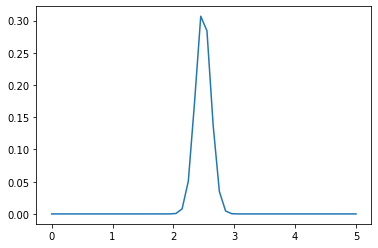

In [15]:
_p = np.diff(np.linspace(0, 5)).mean() * norm(m_mean, m_std).pdf(np.linspace(0, 5))
plt.plot(np.linspace(0, 5), _p)
print(p.sum())

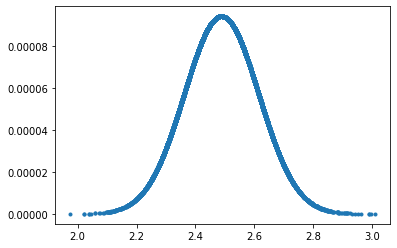

In [16]:
plt.plot(samples1['m'], p, '.')

In [17]:
E_m = np.sum(samples1['m'] * p)

In [18]:
E_m

DeviceArray(2.487682, dtype=float32)

In [19]:
samples = samples1

In [20]:
p_thetas = []
for theta_name, theta_samples in samples.items():
    theta_dist = dist.Normal(loc=theta_samples.mean(), scale=theta_samples.std())
    theta_pdf_values = np.exp(theta_dist.log_prob(theta_samples))
    p_theta = theta_pdf_values / theta_pdf_values.sum()
    p_thetas.append(p_theta)
joint_p = np.prod(p_thetas, axis=0)

In [21]:
joint_p.max()

DeviceArray(8.783015e-09, dtype=float32)